In [1]:
!nvidia-smi

Fri Apr 29 09:39:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8     5W /  N/A |    156MiB /  4096MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [3]:
# !mkdir ./content/saved_models

# Imports and Utility functions

In [4]:
#!pip3 install tensorboard --upgrade

In [5]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import transforms, models
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

Make some directory

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-04-28 09:16:34--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  60.8MB/s    in 2.7s    

2022-04-28 09:16:37 (60.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!ls

CIFAR10  cifar	cifar-10-python.tar.gz	data  mat  shingan-ml  snap


In [ ]:
!mkdir exp
!mkdir exp/content

In [ ]:
!ls

CIFAR10  cifar	cifar-10-python.tar.gz	data  exp  mat	shingan-ml  snap


In [ ]:
!tar -xvf cifar-10-python.tar.gz -C exp/content

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# Utilities

In [ ]:
import pickle
def unpickle(file):
    with open(file, "rb") as f:
        dict = pickle.load(f, encoding="bytes")
    return dict

## Metrics

In [ ]:
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))

def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

Accuracy

In [ ]:
def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    return tn/(tn+fn)

Performance

In [ ]:
def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["Injury", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [class_labels[i],
                     round(tp(y[:, i], pred[:, i]),3),
                     round(tn(y[:, i], pred[:, i]),3),
                     round(fp(y[:, i], pred[:, i]),3),
                     round(fn(y[:, i], pred[:, i]),3),
                     round(acc(y[:, i], pred[:, i], thresholds[i]),3),
                     round(prevalence(y[:, i]),3),
                     round(sens(y[:, i], pred[:, i], thresholds[i]),3),
                     round(spec(y[:, i], pred[:, i], thresholds[i]),3),
                     round(ppv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(npv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(auc(y[:, i], pred[:, i]),3),
                     round(f1(y[:, i], pred[:, i] > thresholds[i]),3),
                     round(thresholds[i], 3)]

    df = df.set_index("Injury")
    return df

Bootstrap

In [ ]:
def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

Confident interval

In [ ]:
def get_confidence_intervals(y,pred,class_labels):
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs

## Plotting

#### Accuracy

In [ ]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### Loss

In [ ]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### ROC

In [ ]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### Precision and Recall

In [ ]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### Performance Metrics with Errorbars

In [ ]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metrics][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

plot_features

In [ ]:
def plot_features(model, num_classes, num_feats, batch_size, vdl):
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1, _ in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)#.view((-1,3,224,224))
            #y = y.to(device = 'cuda:0')#.view((-1,1))
            out = model(x1)
            out = out.cpu().numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    #plt.scatter(x_feats[:,1],x_feats[:,0])
    num_samples = int(batch_size*(val_images.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        plt.scatter(x_feats[val_labels[:num_samples]==i,1],x_feats[val_labels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

## Augmentation

Cutout

In [ ]:
class Cutout(nn.Module):
    def __init__(self, seed = 0):
        self.seed = seed
        
    def get_start_index(self,L):
        return np.random.randint(L)
    
    def __call__(self,frame):
        channels, h, w = frame.shape
        #print(frames.shape)
        size = h//4
        n_squares = np.random.randint(1,3,1)[0]
        new_image = frame
        for _ in range(n_squares):
            y = np.clip(self.get_start_index(h), size // 2, h - size//2)
            x = np.clip(self.get_start_index(w), size // 2, w - size//2)
            
            y1 = np.clip(y - size // 2, 0, h)
            y2 = np.clip(y + size // 2, 0, h)
            x1 = np.clip(x - size // 2, 0, w)
            x2 = np.clip(x + size // 2, 0, w)
            new_image[:, y1:y2,x1:x2] = 0
        return new_image

Gaussian Noise

In [ ]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Data generator

In [ ]:
s = 0.5
data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomResizedCrop(32,(0.8,1.0)),
                                      transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                                                          transforms.RandomGrayscale(p=0.2)])
                                      ])

In [ ]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,data_transforms):
        self.phase = phase
        self.imgarr = imgarr
        self.transforms = data_transforms

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

## Model

PreModel

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    
class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_batchnorm = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_batchnorm
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):  # with pretrain
    def __init__(self,base_model,base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer
        
        #PRETRAINED MODEL
        self.pretrained = self.base_model
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(2048, 2048, self.base_out_layer)
    

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

DownStream Model

In [ ]:
class DSModel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()
        
        self.premodel = premodel
        
        self.num_classes = num_classes

        #TAKING OUTPUT FROM AN INTERMEDITATE LAYER
        #PREPRAING THE TRUNCATED MODEL
        
        for p in self.premodel.parameters():
            p.requires_grad = False
            
        for p in self.premodel.projector.parameters():
            p.requires_grad = False
        
        
        self.lastlayer = nn.Linear(2048,self.num_classes)
        

        
    def forward(self,x):
        out = self.premodel.pretrained(x)
        
        out = self.lastlayer(out)
        return out

## Optimizer

LARS

In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(self, 
                 params, 
                 lr=required,
                 momentum=0.9,
                 use_nesterov=False,
                 weight_decay=0.0,
                 exclude_from_weight_decay=None,
                 exclude_from_layer_adaptation=None,
                 classic_momentum=True,
                 eeta=EETA_DEFAULT):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """
                
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.epoch = 0
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        self.exclude_from_layer_adaptation = exclude_from_layer_adaptation if exclude_from_layer_adaptation else exclude_from_weight_decay
        
    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

load_optimizer (maybe don't need it)

In [ ]:
def load_optimizer(arg_optimizer, model, batch_size):

    scheduler = None
    if arg_optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif arg_optimizer == "LARS":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = LARS(
            [params for params in model.parameters() if params.requires_grad],
            lr=0.1,
            weight_decay=1e-6,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler

def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('./cifar/content/saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

## Loss

SimCLR_Loss

In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
        
        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        # Make simlilarity matrix with cosine function from paper
        N = 2 * self.batch_size 
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        sim_i_j = torch.diag(sim, self.batch_size)  # diagonal of rowi_colj
        sim_j_i = torch.diag(sim, -self.batch_size) # diagonal of rowj_coli
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
                
        #SIMCLR
        # labels = torch.zeros(N).to(positive_samples.device)
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Train and validation

In [ ]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [ ]:
# Loss on val loader
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, (x_i, x_j) in enumerate(valid_loader):
        
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

# Dataset and DataLoader

In [ ]:
train_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
data_batches = np.array([],dtype=np.uint8).reshape((0,3072))
label_batches = np.array([])
for file in train_files:
    data_dict = unpickle('exp/content/cifar-10-batches-py/' + file)
    data = data_dict[b'data']
    data_batches = np.append(data_batches,data,axis=0)
    label_batches = np.append(label_batches,data_dict[b'labels'])
print(data_batches.shape, label_batches.shape)

(50000, 3072) (50000,)


In [ ]:
test_batch = np.array([],dtype=np.uint8).reshape((0,3072))
test_labels = np.array([])

data_dict = unpickle('exp/content/cifar-10-batches-py/test_batch')
data = data_dict[b'data']
test_batch = np.append(test_batch,data,axis=0)
test_labels = np.append(test_labels,data_dict[b'labels'])
print(test_batch.shape, test_labels.shape)

(10000, 3072) (10000,)


In [ ]:
images = data_batches.reshape((-1,3,32,32)).astype(np.float)
test_images = test_batch.reshape((-1,3,32,32)).astype(np.float)

print(images.shape, test_images.shape)

(50000, 3, 32, 32) (10000, 3, 32, 32)


In [ ]:
images = images
test_images = test_images

In [ ]:
train_images = np.moveaxis(images,1,3)
test_images = np.moveaxis(test_images,1,3)

In [ ]:
labels = label_batches.astype(np.int)
test_labels = test_labels.astype(np.int)

In [ ]:
lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

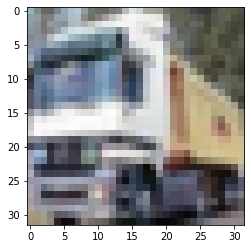

truck


In [ ]:
# Image example
plt.imshow(train_images[1]/255.0)
plt.show()
print(lab_dict[labels[1]])

In [ ]:
train_images = images[:40000]
val_images = images[40000:]
train_labels = labels[:40000]
val_labels = labels[40000:]

In [ ]:
dg = C10DataGen('train',train_images, data_transforms)#train_df)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

In [ ]:
vdg = C10DataGen('valid',val_images, data_transforms)#_df)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

(array([1014., 1014.,  952., 1016.,  997., 1025.,  980.,  977., 1003.,
        1022.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

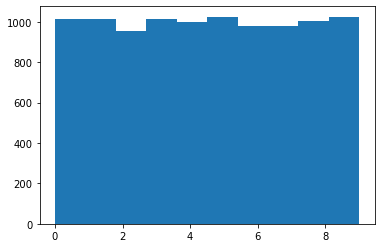

In [ ]:
plt.hist(val_labels)

Dataset

In [ ]:
train_set = C10DataGen('train',train_images, data_transforms) #train_df)
val_set = C10DataGen('valid',val_images, data_transforms)#_df)

In [ ]:
np.unique(val_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

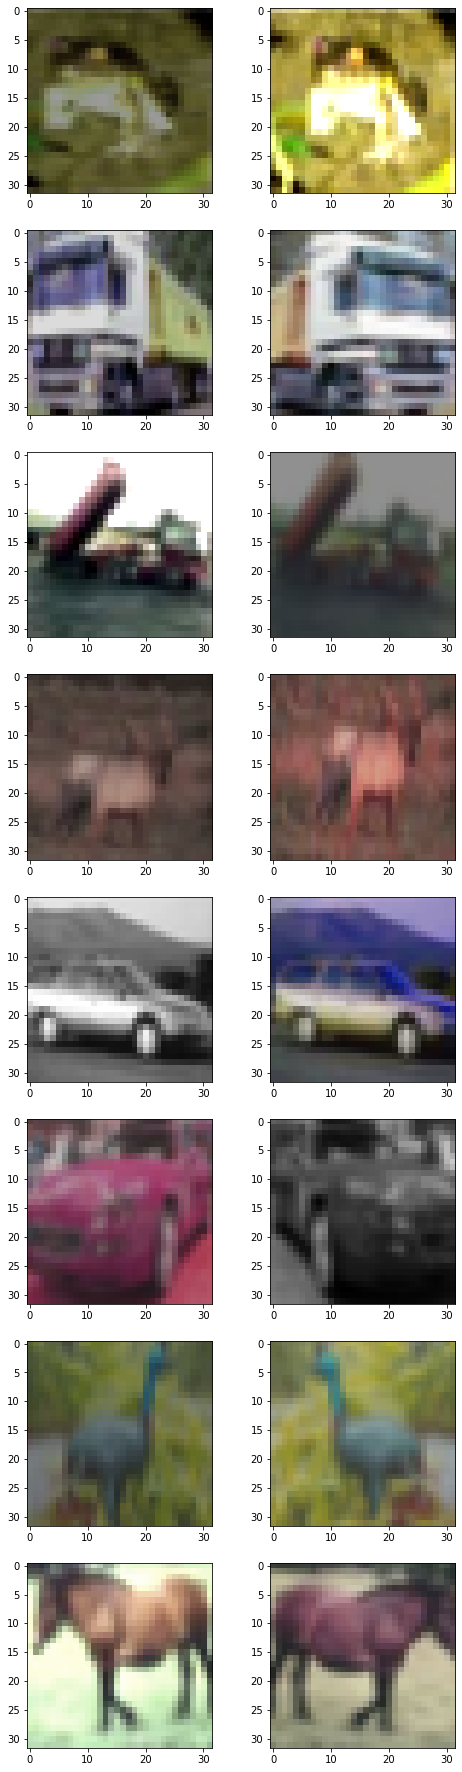

In [ ]:
MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
# Image after standardization
fig,axs = plt.subplots(8,2,figsize=(8,32))
for step,(x1,x2) in enumerate(dl):
    for i in range(8):
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

# Model

In [ ]:
base_model = models.resnet50(pretrained=True)
model = PreModel(base_model, 128)
model = model.to('cuda:0')

# Training

Feature before train

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


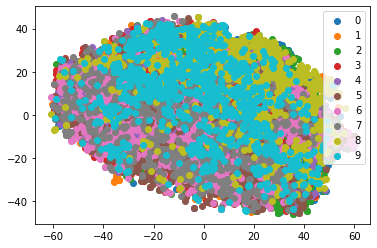

In [ ]:
plot_features(model.pretrained, 10, 2048, 128, vdl)

In [ ]:
!mkdir exp/content/saved_models

In [ ]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch     0: adjusting learning rate of group 0 to 2.0000e-01.


In [ ]:
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

In [ ]:
nr = 0
global_step = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

Main

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch in range(100):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    start_time = time.time()

    model.train()
    train_loss_epoch = train(dl, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion)

    if nr == 0:
        tr_loss.append(train_loss_epoch / len(dl))
        val_loss.append(val_loss_epoch / len(vdl))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {train_loss_epoch / len(dl)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time() - start_time)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.pretrained, 10, 2048, 128) #, valimages)

## end training
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

Epoch [0/100]	


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 14.76 GiB total capacity; 13.11 GiB already allocated; 15.75 MiB free; 13.62 GiB reserved in total by PyTorch)

In [ ]:
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_260621.pt")

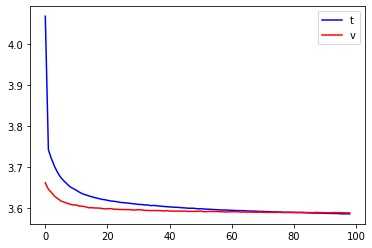

In [ ]:
plt.plot(tr_loss,'b-')
plt.plot(val_loss,'r-')
plt.legend(['t','v'])
plt.show()

# Downstream

## Model

In [ ]:
dsmodel = DSModel(model, 10).to('cuda:0')

In [ ]:
NUM_FRAMES = 16
NUM_CLASSES = 10

##### CIFAR 10

In [ ]:
class DSDataGen(Dataset):
    def __init__(self, phase, imgarr,labels,num_classes=NUM_CLASSES):
        
        self.phase = phase
        self.num_classes = num_classes
        self.imgarr = imgarr
        self.labels = labels
        
        self.indices = list(range(self.imgarr.shape[0]))
        
        self.randomcrop = transforms.RandomResizedCrop(32,(0.8,1.0))
    
    def __len__(self):
        return self.imgarr.shape[0]
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        
        x = self.imgarr[idx]
        
        img = torch.from_numpy(x).float()
            
        #GET CLIP FRAMES
        #for i in range(4):
        label = self.labels[idx]

        #AUGMENT FRAMES
        if self.phase == 'train':
            img  = self.randomcrop(img)

        img = self.preprocess(img)
        
        return img, label
    
    def on_epoch_end(self):
        idx = random.sample(population = list(range(self.__len__())),k = self.__len__())
        self.imgarr = self.imgarr[idx]
        self.labels = self.labels[idx]
        
    def preprocess(self,frame):
        frame = frame / 255.0
        frame = (frame-MEAN)/STD
        
        return frame
    
    

##### DATALOADERS

In [ ]:
dg = DSDataGen('train', trimages,trlabels,
               batch_size=1, num_classes=NUM_CLASSES)

dl = DataLoader(dg,batch_size = 32, drop_last = True)

In [ ]:
vdg = DSDataGen('valid', valimages, vallabels,
               batch_size=1,num_classes=NUM_CLASSES)

vdl = DataLoader(vdg,batch_size = 32, drop_last = True)

## Main training

In [ ]:
dsoptimizer = torch.optim.SGD([params for params in dsmodel.parameters() if params.requires_grad],lr = 0.01, momentum = 0.9)

#dsoptimizer = torch.optim.Adam([params for params in dsmodel.parameters() if params.requires_grad],lr=1e-5)

lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=0.98, last_epoch=-1, verbose = True) #CosineAnnealingWarmRestarts(dsoptimizer,5,eta_min = 1e-6,last_epoch = -1, verbose = True) 

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
tr_ep_loss = []
tr_ep_acc = []
tr_ep_auc = []
val_ep_loss = []
val_ep_acc = []
val_ep_auc = []

min_val_loss = 100.0

batch_size = 1
EPOCHS = 10
num_cl = 10
accumulation_steps = 1

In [ ]:
for epoch in range(20):
    
    stime = time.time()
    print("=============== Epoch : %3d ==============="%(epoch+1))
    
    loss_sublist = np.array([])
    acc_sublist = np.array([])
    
    #iter_num = 0
    dsmodel.train()
    
    dsoptimizer.zero_grad()
    
    for x,y in dl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        
        z = dsmodel(x)
        
        dsoptimizer.zero_grad()
        
        tr_loss = loss_fn(z,y) #/accumulation_steps #y.to(dtype=torch.float), z)
        tr_loss.backward()

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))
        
        #if (iter_num+1)%accumulation_steps==0:
        dsoptimizer.step()
        #dsoptimizer.zero_grad()
        
        loss_sublist = np.append(loss_sublist, tr_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
        
        #iter_num+=1
    
    print('ESTIMATING TRAINING METRICS.............')
    
    print('TRAINING BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist)*accumulation_steps)
    print('TRAINING BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('TRAINING AUC SCORE: ',roc_auc_score(gt,preds))
    
    tr_ep_loss.append(np.mean(loss_sublist))
    tr_ep_acc.append(np.mean(acc_sublist))
    
    #tr_ep_auc.append(roc_auc_score(gt, preds))
    
    
    
    print('ESTIMATING VALIDATION METRICS.............')
    
    dsmodel.eval()
    
    loss_sublist = np.array([])
    acc_sublist = np.array([])
    
    with torch.no_grad():
        for x,y in vdl:
            x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
            y = y.to(device = 'cuda:0')
            z = dsmodel(x)

            val_loss = loss_fn(z,y)

            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

            loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)
            

    print('VALIDATION BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
    print('VALIDATION BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('VALIDATION AUC SCORE: ',roc_auc_score(gt, preds))
    
    val_ep_loss.append(np.mean(loss_sublist))
    val_ep_acc.append(np.mean(acc_sublist))
    
    #val_ep_auc.append(roc_auc_score(gt, preds))
    
    lr_scheduler.step()
    
    dg.on_epoch_end()
    
    if np.mean(loss_sublist) <= min_val_loss:
        min_val_loss = np.mean(loss_sublist) 
        print('Saving model...')
        torch.save({'model_state_dict': dsmodel.state_dict(),
                'optimizer_state_dict': dsoptimizer.state_dict()}, 
               '/content/saved_models/cifar10_rn50_p128_sgd0p01_decay0p98_all_lincls_300621.pt')
    
    print("Time Taken : %.2f minutes"%((time.time()-stime)/60.0))

=============== Epoch :  11 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.4799806905925274
TRAINING BINARY ACCURACY:  0.836875
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  0.4514698210435036
VALIDATION BINARY ACCURACY:  0.8412459935897436
Adjusting learning rate of group 0 to 8.1707e-03.
Time Taken : 0.73 minutes
=============== Epoch :  12 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.4740232384800911
TRAINING BINARY ACCURACY:  0.8384
ESTIMATING VALIDATION METRICS.............
VALIDATION BINARY CROSSENTROPY LOSS:  0.43004642345775396
VALIDATION BINARY ACCURACY:  0.8538661858974359
Adjusting learning rate of group 0 to 8.0073e-03.
Time Taken : 0.73 minutes
=============== Epoch :  13 ===============
ESTIMATING TRAINING METRICS.............
TRAINING BINARY CROSSENTROPY LOSS:  0.4704592683672905
TRAINING BINARY ACCURACY:  0.837875
ESTIMATING VALIDATION MET

## Visualization

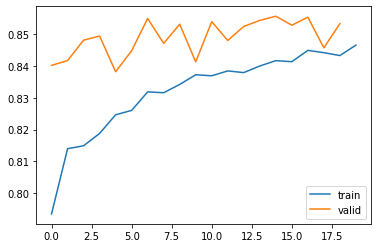

In [ ]:
plt.plot([t for t in tr_ep_acc])
plt.plot([t for t in val_ep_acc])
plt.legend(['train','valid'])

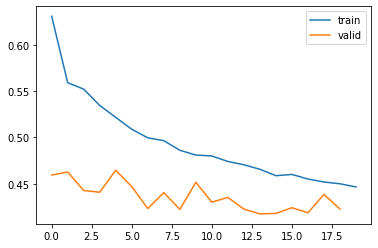

In [ ]:
plt.plot(tr_ep_loss)
plt.plot(val_ep_loss)
plt.legend(['train','valid'])

AUC

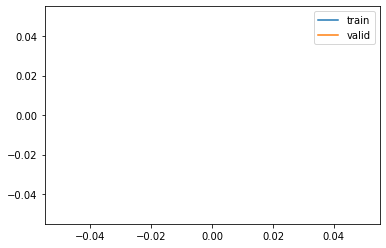

In [ ]:
plt.plot([t for t in tr_ep_auc])
plt.plot([t for t in val_ep_auc])
plt.legend(['train','valid'])

In [ ]:
tdg = DSDataGen('test', testimages, testlabels, num_classes=10)

tdl = DataLoader(tdg, batch_size = 32, drop_last = True)

dsmodel.eval()
    
loss_sublist = np.array([])
acc_sublist = np.array([])

with torch.no_grad():
    for x,y in vdl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        z = dsmodel(x)

        val_loss = loss_fn(z,y)

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)

print('TEST BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
print('TEST BINARY ACCURACY: ',np.mean(acc_sublist))